# Predicting churn using Spark

This notebook contains **an analysis that predicts churn rates** for a hypothetical music streaming app service called Sparkify. The analysis was done using **Spark with the PySpark Python API**  and follows the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) process model.

The data for this analysis was provided by Udacity as part of the capstone project in the Data Science Nanodegree program. The [medium-sized version of the data](https://video.udacity-data.com/topher/2018/December/5c1d6681_medium-sparkify-event-data/medium-sparkify-event-data.json) was used in this analysis.

## Libraries

Options were provided to either use a workspace on the Udacity platform, an AWS cluster or IBM Watson. Fortunately, after doing some research, [a blog post was found that shared steps on how to set up Spark locally on a Windows](https://medium.com/@naomi.fridman/install-pyspark-to-run-on-jupyter-notebook-on-windows-4ec2009de21f).

The following are required to access Spark through Jupyter on Windows (with Anaconda)

In [1]:
# import libraries
import findspark
findspark.init()
findspark.find()

import pyspark
findspark.find()

'C:\\spark\\spark-2.4.5-bin-hadoop2.7'

The following are a combination of the Spark and Python libraries that were imported to support the analysis required

In [2]:
# create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

In [3]:
# functions to import
from pyspark.sql.functions import count, udf, col, countDistinct, to_timestamp, first, lit
import pyspark.sql.functions as func
import datetime
from time import time

In [4]:
# python ds imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

Spark's standard JSON reader was used to load the .json dataset

In [5]:
# Read in data
# You may want to download the data locally first and store in the same directory as this notebook
df = spark.read.json('medium-sparkify-event-data.json')

In [6]:
# Verify data was read successfully 
df.head(2)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98')]

## Clean Data

A tip was provided that indicated that there may be some missing data. After doing some review, it was found that **there were rows that did not have any userID**. As a result, **these rows were removed** to avoid the data analysis being impacted by incomplete data.

In [7]:
# Only keep rows that have userID
df = df.where("userID != ''")

Two columns (`ts` & `registration`) were found that represented dates but were in a different format. To ensure that these columns could be analyzed properly, they were converted to the appropriate data type.

In [8]:
# Convert fields with timestamps to Date and Timestamp
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('event_time', convert_ts('ts'))
df = df.withColumn('registration_time', convert_ts('registration'))

Overall, there are over ~52k rows. Each row represented an event.

In [9]:
df.count()

528005

## Exploratory Data Analysis
In this section of the notebook, the data was explored to determine the fields / columns that could serve as the features to predict churn.

### Define Churn

In this analysis, **churn** refers to when users stop using the Sparkify service.

To determine users who have churned in the current dataset, a new `Churn` column was created. This new column was set to '1' if the page column on the row had `Cancellation Confirmation`. More importantly, the new `Churn` column would be used as the label column during the modeling process which occurs at the end of the analysis.

In [10]:
# Creating Churn column
df_full = df.withColumn('churn', func.when(func.col('page') == 'Cancellation Confirmation', 1).otherwise(0))

A `Downgrade` column was also created. This column was set to '1' if the page column on the row had `Downgrade`. This would be used as a feature for modeling.

In [11]:
# Creating Downgrade column
df_full = df_full.withColumn('downgrade', func.when(func.col('page') == 'Downgrade', 1).otherwise(0))

In [12]:
# Confirm creation of new columns
df_full.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- churn: integer (nullable = false)
 |-- downgrade: integer (nullable = false)



### Descriptive data
It is important to get an idea of the 'basics', starting with the count of distinct users in the dataset, which was found to be 448.

In [13]:
# Count of distinct users
df_full.select("userID").distinct().count()

448

All distinct IDs were collected in a list in case they were required to be used during the analysis.

In [14]:
# Get distinct userIds into a list; to be used in later queries
distinct_userIds = df_full.select("userID").distinct().collect()

distinct_userId_list = []
for row in distinct_userIds:
    distinct_userId_list.append(row[0])

### User data exploration
In this section, an analysis was done of the users who stayed (non-churn) and the users who churned (churn). The analysis looked to compare:
* Non-Churn vs Churn data
* Churn users by month, to see if there was any pattern
* Churn users by gender, to see if there was any pattern
* Churn users by level (paid vs free), to see if there was any pattern

In [15]:
# To get able to get month data
from pyspark.sql.functions import format_number,dayofmonth,hour,dayofyear,month,year,weekofyear,date_format

# Get month data and add other columns needed
churn_events = df_full.orderBy('churn', ascending=False).withColumn("month",month(df_full['event_time'])).groupBy('userId').agg(first('event_time').alias("event_time"),
                                                                                                                                first('gender').alias("gender"),
                                                                                                                                first('level').alias("level"),
                                                                                                                                first('month').alias("month"),
                                                                                                                                first('churn').alias("churn"))

#### Non-Churn vs Churn

In [16]:
# Convert to pandas for visualization
churn_events_pd = churn_events.groupBy('churn').count().toPandas()

Text(0.5, 1.0, 'Non-Churn vs Churn')

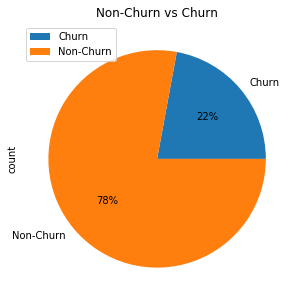

In [17]:
# Create pandas pie chart
churn_events_labels = 'Churn','Non-Churn'
churn_events_plt = churn_events_pd.plot.pie(y='count', labels=churn_events_labels, figsize = (5,5), autopct='%1.0f%%')
churn_events_plt.set_title("Non-Churn vs Churn")

In [18]:
# Filter for if churn == 1 and group by gender
churn_events.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   99|
|    0|  349|
+-----+-----+



#### Churn users by month

In [19]:
# Filter for if churn == 1 and group by gender
churn_events.filter(churn_events['churn'] == 1).groupBy('month').count().show()

+-----+-----+
|month|count|
+-----+-----+
|   10|   49|
|   11|   50|
+-----+-----+



#### Churn users by gender

In [20]:
# Filter for if churn == 1 and group by gender
churn_events.filter(churn_events['churn'] == 1).groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|   45|
|     M|   54|
+------+-----+



#### Churn users by level (paid vs free)

In [21]:
# Filter for if churn == 1 and group by level
churn_events.filter(churn_events['churn'] == 1).groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|   32|
| paid|   67|
+-----+-----+



> Over a span of ~2 months, about 22% (99/448) of users churned. Most users were male and were paid users. Month does not seem to be a factor.

### Event data exploration

The 'page' column was a key indicator in the behaviors / actions of users. For this reason, it was important to look at this column in-detail

Separating non-churn and churn users so that we can gather data specific for each user type

In [22]:
# Get ids of users who churned
churn_users_ids = (df_full.select("userID").filter(df_full['churn'] == 1)
                                           .orderBy('userID', ascending=False)
                                           .distinct()
                                           .collect())

churn_users_ids_list = []
for row in churn_users_ids:
    if row not in churn_users_ids_list:
        churn_users_ids_list.append(row[0])

# Getting all events from id list of users who churned
churn_users_events = df_full.filter(col('userId').isin(churn_users_ids_list))

In [23]:
# Getting all events from id list of users who stayed
non_churn_users_events = df_full.filter(~col('userId').isin(*churn_users_ids_list))

Creating and merging the appropriate dataframe / queries so that we can compare behaviors / actions of each user type to see if there are any patterns.

In [24]:
# Gather page event data for churn users
# Get the percentage of events for each page
from pyspark.sql.functions import format_number

churn_users_events_pages = churn_users_events.orderBy('page').groupBy('page').count()
churn_users_events_pages = churn_users_events_pages.withColumn("churn_pc",(format_number(((func.col('count')/churn_users_events.count())*100),2)))
churn_users_events_pages = churn_users_events_pages.select(['page','churn_pc'])

In [25]:
# Gather page event data for non churn users
# Get the percentage of events for each page
non_churn_users_events_pages = non_churn_users_events.orderBy('page').groupBy('page').count()
non_churn_users_events_pages = non_churn_users_events_pages.withColumn("non_churn_pc",(format_number(((func.col('count')/non_churn_users_events.count())*100),2)))
non_churn_users_events_pages = non_churn_users_events_pages.select(['page','non_churn_pc'])

In [26]:
churn_vs_non_churn_events = churn_users_events_pages.join(non_churn_users_events_pages, on=['page'], how='outer')

Tabular view for comparison / analysis

In [27]:
churn_vs_non_churn_events.show()

+--------------------+--------+------------+
|                page|churn_pc|non_churn_pc|
+--------------------+--------+------------+
|              Cancel|    0.10|        null|
|    Submit Downgrade|    0.03|        0.02|
|         Thumbs Down|    1.12|        0.88|
|                Home|    3.65|        3.61|
|           Downgrade|    0.80|        0.70|
|         Roll Advert|    2.11|        1.32|
|              Logout|    1.14|        1.13|
|       Save Settings|    0.10|        0.11|
|Cancellation Conf...|    0.10|        null|
|               About|    0.18|        0.20|
|            Settings|    0.60|        0.55|
|     Add to Playlist|    2.18|        2.38|
|          Add Friend|    1.48|        1.54|
|            NextSong|   81.39|       82.13|
|           Thumbs Up|    4.15|        4.60|
|                Help|    0.50|        0.50|
|             Upgrade|    0.23|        0.17|
|               Error|    0.09|        0.10|
|      Submit Upgrade|    0.07|        0.05|
+---------

Bar chart view for comparison / visualization

In [28]:
# Visualization
churn_vs_non_churn_events_pd = churn_vs_non_churn_events.toPandas()

In [29]:
churn_vs_non_churn_events_pd['churn_pc'] = churn_vs_non_churn_events_pd['churn_pc'].astype('float')
churn_vs_non_churn_events_pd['non_churn_pc'] = churn_vs_non_churn_events_pd['non_churn_pc'].astype('float')

Text(0.5, 1.0, 'Pages / Events: Churn Users vs Non Churn Users')

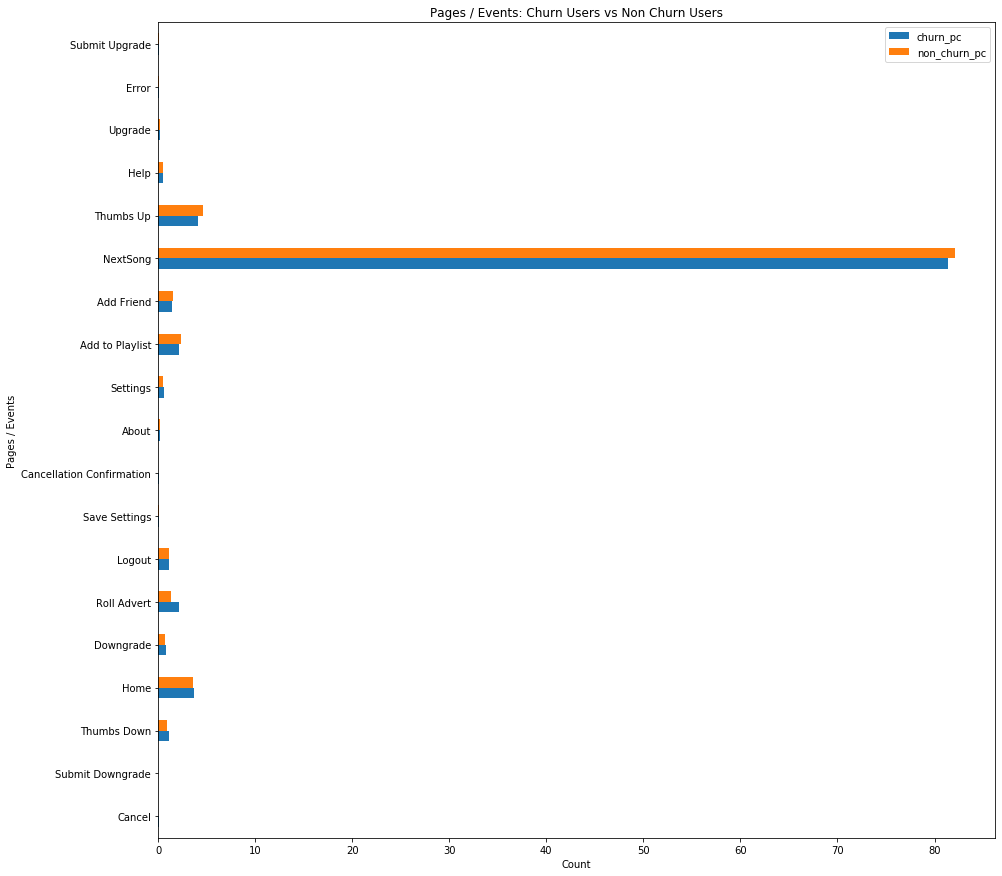

In [30]:
churn_vs_non_churn_events_plt = churn_vs_non_churn_events_pd.plot(kind = 'barh', figsize = (15,15))
churn_vs_non_churn_events_plt.legend = (["churn_pc", "non_churn_pc"])
churn_vs_non_churn_events_plt.set_yticklabels(list(churn_vs_non_churn_events_pd['page'].values))
churn_vs_non_churn_events_plt.set_xlabel("Count")
churn_vs_non_churn_events_plt.set_ylabel("Pages / Events")
churn_vs_non_churn_events_plt.set_title("Pages / Events: Churn Users vs Non Churn Users")

>By analyzing the events (i.e. page data), we get a good idea of what features we can get out of this data by looking at events that have the most occurences by each user type.  

### Preparing data for feature engineering

In addition to the descriptive, user and event data, 'time' related data such as the # of events for each user, how long their sessions were and how long a user has been a member / subscriber to Sparkify will also be explored as features.

The idea behind this is that a user's behavior or probability to churn would have to be explored over a period of time. This is why it is good to include 'time' related data.

#### Events and Sessions
* Count of events per session

In [31]:
df_events_per_session = (df_full.select(['userId',
                                     'gender',
                                     'length',
                                     'level',
                                     'page',
                                     'sessionId',
                                     'downgrade',
                                     'registration_time'])
                                 .groupby("userId")
                                 .agg(count("sessionId").alias("events_per_user"),
                                      first('gender').alias("gender"), 
                                      first('level').alias("level"),
                                      countDistinct("sessionId").alias("sessions_per_user")))

In [32]:
df_events_per_session = (df_events_per_session.withColumn("events_per_session",(func.col('events_per_user')/func.col('sessions_per_user')))
                                             .drop("events_per_user")
                                             .drop("sessions_per_user"))

#### Roll Adverts
* Count of roll adverts seen by a user
* Based on the event data analysis, churn users seem to have more roll adverts

In [33]:
# Get roll adverts per user
roll_adverts_per_user = (df_full.filter(df_full['page']=='Roll Advert')
                               .groupby("userId").count()
                               .withColumn("roll_adverts_per_user",col("count"))
                               .drop("count"))

In [34]:
roll_adverts_per_user.show(5)

+------+---------------------+
|userId|roll_adverts_per_user|
+------+---------------------+
|   296|                    9|
|100010|                   22|
|200002|                   11|
|   125|                    6|
|     7|                   35|
+------+---------------------+
only showing top 5 rows



#### Session Length
* Total usage of service
* The idea is to see if a user who uses the service less would be more likely to churn

In [35]:
# Calculate average length per session
total_length_per_user = (df_full.select(['userId','length'])
                               .groupBy("userId").sum()
                               .withColumn("total_length_per_user",col("sum(length)"))
                               .drop("sum(length)"))

In [36]:
total_length_per_user.show(5)

+------+---------------------+
|userId|total_length_per_user|
+------+---------------------+
|   296|   28314.150059999996|
|100010|   25870.950739999997|
|200002|    78695.82683999998|
|   125|          15813.77107|
|    51|    66817.21162999999|
+------+---------------------+
only showing top 5 rows



#### Thumbs Up vs Thumbs Down
* Comparison of Thumbs Up vs Thumbs Down
* In general, a 'Thumbs Down' would indicate disastifaction
* The idea is that if there are more 'Thumbs Down', would that lead to churn?
* Based on the event data analysis, churn users seem to have more Thumbs Down
* Given that not every user may do a Thumbs Up or Thumbs Down, an attempt was made to be creative and create a Thumbs Up and Thumbs Down ratio

In [37]:
# Num of Thumbs Down per user
thumbs_down_per_user = (df_full.filter(df_full['page']=='Thumbs Down')
                              .groupby("userId").count()
                              .withColumn("thumbs_down_per_user",col("count"))
                              .drop("count"))

In [38]:
# Num of Thumbs Up per user
thumbs_up_per_user = (df_full.filter(df_full['page']=='Thumbs Up')
                            .groupby("userId").count()
                            .withColumn("thumbs_up_per_user",col("count")).drop("count"))

In [39]:
# Merge events / sessions and thumbs actions data
thumbs_actions = (thumbs_down_per_user.join(thumbs_up_per_user, on=['userId'], how='left')
                                     .withColumn("thumbs_actions_total",(func.col('thumbs_down_per_user') + func.col('thumbs_up_per_user')))
                                     .withColumn("thumbs_down_ratio",(func.col('thumbs_down_per_user')/func.col('thumbs_actions_total')))
                                     .withColumn("thumbs_up_ratio",(func.col('thumbs_up_per_user')/func.col('thumbs_actions_total')))
                                     .drop("thumbs_down_per_user")
                                     .drop("thumbs_up_per_user")
                                     .drop("thumbs_actions_total"))

In [40]:
thumbs_actions.show(5)

+------+--------------------+------------------+
|userId|   thumbs_down_ratio|   thumbs_up_ratio|
+------+--------------------+------------------+
|100010| 0.42857142857142855|0.5714285714285714|
|200002|                0.25|              0.75|
|   125|                0.25|              0.75|
|   124|  0.1282051282051282|0.8717948717948718|
|    51|0.058823529411764705|0.9411764705882353|
+------+--------------------+------------------+
only showing top 5 rows



#### Downgrade
* Comparison of Downgrade events
* Based on the event data analysis, churn users seem to have more Downgrade events

In [41]:
# Calculate average length per session
downgrade_per_user = (df_full.filter(df_full['page']=='Downgrade')
                            .groupby("userId").count().withColumn("downgrade_per_user",col("count")).drop("count"))

In [42]:
downgrade_per_user.show(5)

+------+------------------+
|userId|downgrade_per_user|
+------+------------------+
|   296|                 1|
|200002|                 3|
|    51|                 4|
|   124|                21|
|   205|                10|
+------+------------------+
only showing top 5 rows



#### Next Song (Songs played)
* Comparison of songs played
* Based on the event data analysis, churn users seem to play less songs

In [43]:
# Calculate average length per session
next_song_per_user = df_full.filter(df_full['page']=='NextSong').groupby("userId").count().withColumn("next_song_per_user",col("count")).drop("count")

In [44]:
next_song_per_user.show(5)

+------+------------------+
|userId|next_song_per_user|
+------+------------------+
|   296|               112|
|100010|                96|
|200002|               310|
|   125|                62|
|    51|               266|
+------+------------------+
only showing top 5 rows



#### Duration as a user
* To see if a user's duration on the platform has any impact on churn

In [45]:
user_member_duration = df_full.select(['userId','event_time','registration_time']).withColumn('member_duration', ((func.unix_timestamp(df_full['event_time']) - func.unix_timestamp(df_full['registration_time']))/3600)/24).groupby("userId").max().withColumn("member_duration",col("max(member_duration)")).drop("max(member_duration)")

In [46]:
user_member_duration.show(5)

+------+------------------+
|userId|   member_duration|
+------+------------------+
|   296| 26.63826388888889|
|100010|14.328449074074074|
|200002| 53.32314814814814|
|   125|105.42211805555554|
|    51| 18.84582175925926|
+------+------------------+
only showing top 5 rows



#### Add to Playlist
* Comparison of user usage of 'Add to Playlist'
* Based on the event data analysis, churn users seem to use the 'Add to Playlist' less which could indicate less usage / engagement

In [47]:
added_to_playlist_per_user = df_full.filter(df_full['page']=='Add to Playlist').groupby("userId").count().withColumn("added_to_playlist_per_user",col("count")).drop("count")

In [48]:
added_to_playlist_per_user.show(5)

+------+--------------------------+
|userId|added_to_playlist_per_user|
+------+--------------------------+
|   296|                         3|
|100010|                         1|
|200002|                         6|
|   125|                         2|
|    51|                         8|
+------+--------------------------+
only showing top 5 rows



#### Add Friend
* Comparison of user usage of 'Add to Friend'
* Based on the event data analysis, churn users seem to use the 'Add Friend' less which could indicate a lower willingness to share with friends which could infer they aren't enjoying the service as much

In [49]:
add_friend_per_user = df_full.filter(df_full['page']=='Add Friend').groupby("userId").count().withColumn("add_friend_per_user",col("count")).drop("count")

In [50]:
add_friend_per_user.show(5)

+------+-------------------+
|userId|add_friend_per_user|
+------+-------------------+
|   296|                  2|
|100010|                  3|
|200002|                  2|
|   125|                  3|
|   124|                 26|
+------+-------------------+
only showing top 5 rows



#### Settings
* Comparison of user click of 'settings'
* Based on the event data analysis, churn users seem to click on 'Settings' more. It may not be a big factor but should not be ruled out based on the event data analysis

In [51]:
settings_clicks_per_user = df_full.filter(df_full['page']=='Settings').groupby("userId").count().withColumn("settings_clicks_per_user",col("count")).drop("count")

In [52]:
settings_clicks_per_user.show(5)

+------+------------------------+
|userId|settings_clicks_per_user|
+------+------------------------+
|   296|                       1|
|200002|                       2|
|   125|                       3|
|    51|                       2|
|   124|                      15|
+------+------------------------+
only showing top 5 rows



#### Home
* Comparison of user click of 'home'
* Based on the event data analysis, churn users seem to click on 'home' more. It may not be a big factor but should not be ruled out based on the event data analysis

In [53]:
home_clicks_per_user = df_full.filter(df_full['page']=='Home').groupby("userId").count().withColumn("home_clicks_per_user",col("count")).drop("count")

In [54]:
home_clicks_per_user.show(5)

+------+--------------------+
|userId|home_clicks_per_user|
+------+--------------------+
|   296|                   7|
|100010|                   3|
|200002|                  23|
|   125|                   2|
|    51|                  17|
+------+--------------------+
only showing top 5 rows



### Merge Data

Merging data analyzed so far

In [55]:
merged_df = (df_events_per_session.join(roll_adverts_per_user, on=['userId'], how='left')
                                  .join(total_length_per_user, on=['userId'], how='left')
                                  .join(thumbs_actions, on=['userId'], how='left')
                                  .join(downgrade_per_user, on=['userId'], how='left')
                                  .join(next_song_per_user, on=['userId'], how='left')
                                  .join(user_member_duration, on=['userId'], how='left')
                                  .join(added_to_playlist_per_user, on=['userId'], how='left')
                                  .join(add_friend_per_user, on=['userId'], how='left')
                                  .join(settings_clicks_per_user, on=['userId'], how='left')
                                  .join(home_clicks_per_user, on=['userId'], how='left')
                                  .withColumn('label', func.when(func.col('userId').isin(churn_users_ids_list), 1).otherwise(0))
                                  .na.fill(0))

#### Categorical columns and removing nulls
* The comparison of the categorical columns of gender and level seem to indicate that these columns may have some bearing on a user to churn. For this reason, they will be converted to numerical values and included as features
* Also, it is important to remove any null data as this would impact the modeling


In [56]:
merged_df = merged_df.withColumn('male', func.when(func.col('gender') == 'M', 1).otherwise(0)).withColumn('female', func.when(func.col('gender') == 'F', 1).otherwise(0)).withColumn('free', func.when(func.col('level') == 'free', 1).otherwise(0)).withColumn('paid', func.when(func.col('level') == 'paid', 1).otherwise(0)).drop("gender").drop("level")

#### Confirm count
Confirm that the data is intact even after the merges

In [57]:
merged_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- events_per_session: double (nullable = false)
 |-- roll_adverts_per_user: long (nullable = true)
 |-- total_length_per_user: double (nullable = false)
 |-- thumbs_down_ratio: double (nullable = false)
 |-- thumbs_up_ratio: double (nullable = false)
 |-- downgrade_per_user: long (nullable = true)
 |-- next_song_per_user: long (nullable = true)
 |-- member_duration: double (nullable = false)
 |-- added_to_playlist_per_user: long (nullable = true)
 |-- add_friend_per_user: long (nullable = true)
 |-- settings_clicks_per_user: long (nullable = true)
 |-- home_clicks_per_user: long (nullable = true)
 |-- label: integer (nullable = false)
 |-- male: integer (nullable = false)
 |-- female: integer (nullable = false)
 |-- free: integer (nullable = false)
 |-- paid: integer (nullable = false)



In [58]:
merged_df.count()

448

## Modeling

In this section, the merged data will be prepared to be used as features that would be ran through 4 algorithms:
* Logistic Regression
* Gradient Boosted Trees
* Decision Tree
* Random Forest

To evaluate each model, we will use Precision, Recall and F1 scores.

### Preparing feature data

In [59]:
# Select columns to use as features
merged_df.columns

['userId',
 'events_per_session',
 'roll_adverts_per_user',
 'total_length_per_user',
 'thumbs_down_ratio',
 'thumbs_up_ratio',
 'downgrade_per_user',
 'next_song_per_user',
 'member_duration',
 'added_to_playlist_per_user',
 'add_friend_per_user',
 'settings_clicks_per_user',
 'home_clicks_per_user',
 'label',
 'male',
 'female',
 'free',
 'paid']

In [60]:
my_cols = merged_df.select(['events_per_session',
 'roll_adverts_per_user',
 'total_length_per_user',
 'thumbs_down_ratio',
 'thumbs_up_ratio',
 'downgrade_per_user',
 'next_song_per_user',
 'member_duration',
 'added_to_playlist_per_user',
 'add_friend_per_user',
 'settings_clicks_per_user',
 'home_clicks_per_user',
 'label',
 'male',
 'female',
 'free',
 'paid'])

In [61]:
my_final_data = my_cols.na.drop()

### Formatting feature data for modeling

In [62]:
from pyspark.ml.feature import VectorAssembler,VectorIndexer, StandardScaler

In [63]:
assembler = VectorAssembler(inputCols=['events_per_session',
 'roll_adverts_per_user',
 'total_length_per_user',
 'thumbs_down_ratio',
 'thumbs_up_ratio',
 'downgrade_per_user',
 'next_song_per_user',
 'member_duration',
 'added_to_playlist_per_user',
 'add_friend_per_user',
 'settings_clicks_per_user',
 'home_clicks_per_user',
 'male',
 'female',
 'free',
 'paid'],outputCol='NumFeatures')

In [64]:
data = assembler.transform(my_final_data)

In [65]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [66]:
from pyspark.ml.classification import LogisticRegression, GBTClassifier, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

### Splitting data into train and test

In [67]:
train, test = data.randomSplit([0.7,.3], seed=42)

### Baseline Modeling
To start, the features will be ran using models without much parameter tuning to establish a baseline

#### Logistic Regression

In [68]:
lr = LogisticRegression(maxIter=10)
paramGrid = ParamGridBuilder() \
    .build()

lr_crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [69]:
lr_start = time()
lr_cvModel = lr_crossval.fit(train)
lr_end = time()

In [70]:
print('lr_cvModel training duration: {} s'.format(lr_end - lr_start))

lr_cvModel training duration: 1680.3615746498108 s


In [71]:
lr_results = lr_cvModel.transform(test)
lr_results.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       1.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [72]:
lr_true_positive = lr_results.filter("label = 1 and prediction = 1").count()
lr_false_positive = lr_results.filter("label = 0 and prediction = 1").count()
lr_false_negative = lr_results.filter("label = 1 and prediction = 0").count()
lr_precision = lr_true_positive / (lr_true_positive + lr_false_positive) 
lr_recall = lr_true_positive / (lr_true_positive + lr_false_negative)
lr_f1 = 2 * lr_precision * lr_recall / (lr_precision + lr_recall)
print('lr_precision: {} '.format(lr_precision))
print('lr_recall: {} '.format(lr_recall))
print('lr_f1: {} '.format(lr_f1))

lr_precision: 0.2631578947368421 
lr_recall: 0.17857142857142858 
lr_f1: 0.2127659574468085 


#### Gradient Boosted Trees

In [73]:
gb = GBTClassifier(maxIter=10,seed=42)
paramGrid = ParamGridBuilder() \
    .build()

gb_crossval = CrossValidator(estimator=gb,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [74]:
gb_start = time()
gb_cvModel = gb_crossval.fit(train)
gb_end = time()

In [75]:
print('gb_cvModel training duration: {} s'.format(gb_end - gb_start))

gb_cvModel training duration: 1819.2531371116638 s


In [76]:
gb_results = gb_cvModel.transform(test)
gb_results.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 20 rows



In [77]:
gb_true_positive = gb_results.filter("label = 1 and prediction = 1").count()
gb_false_positive = gb_results.filter("label = 0 and prediction = 1").count()
gb_false_negative = gb_results.filter("label = 1 and prediction = 0").count()
gb_precision = gb_true_positive / (gb_true_positive + gb_false_positive) 
gb_recall = gb_true_positive / (gb_true_positive + gb_false_negative)
gb_f1 = 2 * gb_precision * gb_recall / (gb_precision + gb_recall)
print('gb_precision: {} '.format(gb_precision))
print('gb_recall: {} '.format(gb_recall))
print('gb_f1: {} '.format(gb_f1))

gb_precision: 0.3076923076923077 
gb_recall: 0.14285714285714285 
gb_f1: 0.1951219512195122 


#### Decision Tree

In [78]:
dt = DecisionTreeClassifier()
paramGrid = ParamGridBuilder() \
    .build()
dt_crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [79]:
dt_start = time()
dt_cvModel = dt_crossval.fit(train)
dt_end = time()

In [80]:
print('dt_cvModel training duration: {} s'.format(dt_end - dt_start))

dt_cvModel training duration: 1471.547533273697 s


In [81]:
dt_results = dt_cvModel.transform(test)
dt_results.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 20 rows



In [82]:
dt_true_positive = dt_results.filter("label = 1 and prediction = 1").count()
dt_false_positive = dt_results.filter("label = 0 and prediction = 1").count()
dt_false_negative = dt_results.filter("label = 1 and prediction = 0").count()
dt_precision = dt_true_positive / (dt_true_positive + dt_false_positive) 
dt_recall = dt_true_positive / (dt_true_positive + dt_false_negative)
dt_f1 = 2 * dt_precision * dt_recall / (dt_precision + dt_recall)
print('dt_precision: {} '.format(dt_precision))
print('dt_recall: {} '.format(dt_recall))
print('dt_f1: {} '.format(dt_f1))

dt_precision: 0.3125 
dt_recall: 0.17857142857142858 
dt_f1: 0.22727272727272727 


#### Random Forest

In [83]:
rf = RandomForestClassifier()
paramGrid = ParamGridBuilder() \
    .build()
rf_crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [84]:
rf_start = time()
rf_cvModel = rf_crossval.fit(train)
rf_end = time()

In [85]:
print('rf_cvModel training duration: {} s'.format(rf_end - rf_start))

rf_cvModel training duration: 1527.0604712963104 s


In [86]:
rf_results = rf_cvModel.transform(test)
rf_results.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [87]:
rf_true_positive = rf_results.filter("label = 1 and prediction = 1").count()
rf_false_positive = rf_results.filter("label = 0 and prediction = 1").count()
rf_false_negative = rf_results.filter("label = 1 and prediction = 0").count()
rf_precision = rf_true_positive / (rf_true_positive + rf_false_positive) 
rf_recall = rf_true_positive / (rf_true_positive + rf_false_negative)
rf_f1 = 2 * rf_precision * rf_recall / (rf_precision + rf_recall)
print('rf_precision: {} '.format(rf_precision))
print('rf_recall: {} '.format(rf_recall))
print('rf_f1: {} '.format(rf_f1))

rf_precision: 0.6666666666666666 
rf_recall: 0.21428571428571427 
rf_f1: 0.3243243243243243 


### Modeling with parameter tuning
Running models with parameter tuning for comparison

#### Logistic Regression

In [88]:
lr_p = LogisticRegression(maxIter=10)
paramGrid_p = ParamGridBuilder() \
    .addGrid(lr_p.elasticNetParam,[0.0, 0.5, 1.0]) \
    .addGrid(lr_p.regParam,[0.0, 0.075, 0.125]) \
    .build()

lr_crossval_p = CrossValidator(estimator=lr_p,
                          estimatorParamMaps=paramGrid_p,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [89]:
lr_start_p = time()
lr_cvModel_p = lr_crossval_p.fit(train)
lr_end_p = time()

In [90]:
print('lr_cvModel_p training duration: {} s'.format(lr_end_p - lr_start_p))

lr_cvModel_p training duration: 1848.4574329853058 s


In [91]:
lr_results_p = lr_cvModel_p.transform(test)
lr_results_p.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       1.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [92]:
lr_true_positive_p = lr_results_p.filter("label = 1 and prediction = 1").count()
lr_false_positive_p = lr_results_p.filter("label = 0 and prediction = 1").count()
lr_false_negative_p = lr_results_p.filter("label = 1 and prediction = 0").count()
lr_precision_p = lr_true_positive_p / (lr_true_positive_p + lr_false_positive_p) 
lr_recall_p = lr_true_positive_p / (lr_true_positive_p + lr_false_negative_p)
lr_f1_p = 2 * lr_precision_p * lr_recall_p / (lr_precision_p + lr_recall_p)
print('lr_precision_p: {} '.format(lr_precision_p))
print('lr_recall_p: {} '.format(lr_recall_p))
print('lr_f1_p: {} '.format(lr_f1_p))

lr_precision_p: 0.2631578947368421 
lr_recall_p: 0.17857142857142858 
lr_f1_p: 0.2127659574468085 


#### Gradient Boosted Trees

In [93]:
gb_p = GBTClassifier(maxIter=10,seed=42)
paramGrid_p = ParamGridBuilder() \
    .addGrid(gb_p.maxIter,[10, 20]) \
    .addGrid(gb_p.maxBins, [20, 60]) \
    .addGrid(gb_p.maxDepth,[2, 4, 6]) \
    .build()

gb_crossval_p = CrossValidator(estimator=gb_p,
                          estimatorParamMaps=paramGrid_p,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [94]:
gb_start_p = time()
gb_cvModel_p = gb_crossval_p.fit(train)
gb_end_p = time()

In [95]:
print('gb_cvModel_p training duration: {} s'.format(gb_end_p - gb_start_p))

gb_cvModel_p training duration: 7189.073091506958 s


In [96]:
gb_results_p = gb_cvModel_p.transform(test)
gb_results_p.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       1.0|
|    1|       0.0|
|    0|       0.0|
|    0|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [97]:
gb_true_positive_p = gb_results_p.filter("label = 1 and prediction = 1").count()
gb_false_positive_p = gb_results_p.filter("label = 0 and prediction = 1").count()
gb_false_negative_p = gb_results_p.filter("label = 1 and prediction = 0").count()
gb_precision_p = gb_true_positive_p / (gb_true_positive_p + gb_false_positive_p) 
gb_recall_p = gb_true_positive_p / (gb_true_positive_p + gb_false_negative_p)
gb_f1_p = 2 * gb_precision_p * gb_recall_p / (gb_precision_p + gb_recall_p)
print('gb_precision_p: {} '.format(gb_precision_p))
print('gb_recall_p: {} '.format(gb_recall_p))
print('gb_f1_p: {} '.format(gb_f1_p))

gb_precision_p: 0.4444444444444444 
gb_recall_p: 0.14285714285714285 
gb_f1_p: 0.21621621621621623 


#### Decision Tree

In [98]:
dt_p = DecisionTreeClassifier()
paramGrid_p = ParamGridBuilder() \
    .addGrid(dt_p.impurity,['entropy', 'gini']) \
    .addGrid(dt_p.maxDepth, [2, 5, 10, 20, 30]) \
    .addGrid(dt_p.maxBins, [10, 20, 40, 80, 100]) \
    .build()
dt_crossval_p = CrossValidator(estimator=dt_p,
                          estimatorParamMaps=paramGrid_p,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [99]:
dt_start_p = time()
dt_cvModel_p = dt_crossval_p.fit(train)
dt_end_p = time()

In [100]:
print('dt_cvModel_p training duration: {} s'.format(dt_end_p - dt_start_p))

dt_cvModel_p training duration: 4414.479683160782 s


In [101]:
dt_results_p = dt_cvModel_p.transform(test)
dt_results_p.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       1.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [102]:
dt_true_positive_p = dt_results_p.filter("label = 1 and prediction = 1").count()
dt_false_positive_p = dt_results_p.filter("label = 0 and prediction = 1").count()
dt_false_negative_p = dt_results_p.filter("label = 1 and prediction = 0").count()
dt_precision_p = dt_true_positive_p / (dt_true_positive_p + dt_false_positive_p) 
dt_recall_p = dt_true_positive_p / (dt_true_positive_p + dt_false_negative_p)
dt_f1_p = 2 * dt_precision_p * dt_recall_p / (dt_precision_p + dt_recall_p)
print('dt_precision_p: {} '.format(dt_precision_p))
print('dt_recall_p: {} '.format(dt_recall_p))
print('dt_f1_p: {} '.format(dt_f1_p))

dt_precision_p: 0.5714285714285714 
dt_recall_p: 0.14285714285714285 
dt_f1_p: 0.2285714285714286 


#### Random Forest

In [103]:
rf_p = RandomForestClassifier()
paramGrid_p = ParamGridBuilder() \
    .addGrid(rf_p.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf_p.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()
rf_crossval_p = CrossValidator(estimator=rf_p,
                          estimatorParamMaps=paramGrid_p,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [104]:
rf_start_p = time()
rf_cvModel_p = rf_crossval_p.fit(train)
rf_end_p = time()

In [105]:
print('rf_cvModel_p training duration: {} s'.format(rf_end_p - rf_start_p))

rf_cvModel_p training duration: 3656.13383102417 s


In [106]:
rf_results_p = rf_cvModel_p.transform(test)
rf_results_p.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|    1|       1.0|
|    1|       0.0|
|    1|       1.0|
|    1|       0.0|
|    0|       1.0|
|    1|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       0.0|
|    1|       0.0|
|    0|       0.0|
|    1|       0.0|
+-----+----------+
only showing top 20 rows



In [107]:
rf_true_positive_p = rf_results_p.filter("label = 1 and prediction = 1").count()
rf_false_positive_p = rf_results_p.filter("label = 0 and prediction = 1").count()
rf_false_negative_p = rf_results_p.filter("label = 1 and prediction = 0").count()
rf_precision_p = rf_true_positive_p / (rf_true_positive_p + rf_false_positive_p) 
rf_recall_p = rf_true_positive_p / (rf_true_positive_p + rf_false_negative_p)
rf_f1_p = 2 * rf_precision_p * rf_recall_p / (rf_precision_p + rf_recall_p)
print('rf_precision_p: {} '.format(rf_precision_p))
print('rf_recall_p: {} '.format(rf_recall_p))
print('rf_f1_p: {} '.format(rf_f1_p))

rf_precision_p: 0.42857142857142855 
rf_recall_p: 0.10714285714285714 
rf_f1_p: 0.17142857142857143 


## Observations / Evaluation

### Baseline
|          Model         | Duration | Precision | Recall | F1 |
|:----------------------:|----------|:----------------:|:-------------:|-----------|
|   Logistic Regression  | 1680.36s  | 0.26             | 0.18          | 0.21      |
| Gradient Boosted Trees | 1819.25s  | 0.31             | 0.14          | 0.20      |
|      Decision Tree     | 1471.55s  | 0.31             | 0.18          | 0.23      |
| Random Forest          | 1527.06s  | 0.67             | 0.21          | 0.31      |

### With Parameter Tuning
|          Model         | Duration | Precision | Recall | F1 |
|:----------------------:|----------|:----------------:|:-------------:|-----------|
|   Logistic Regression  | 1848.46s  | 0.26             | 0.18          | 0.21      |
| Gradient Boosted Trees | 7189.07s | 0.44              | 0.14          | 0.22      |
|      Decision Tree     | 4414.48s  | 0.57             | 0.14          | 0.23      |
| Random Forest          | 3656.13s | 0.43             | 0.11          | 0.17      |

### Observations
* **Random Forest** was the best performing algorithm, with the better overall evaluation (before parameter tuning)
* The precision, recall and f1 calculations were based on only a subset (medium size) of the large 12GB dataset. They may differ for the large dataset
* A significant constraint with the medium dataset is the amount of data available, with only ~22% of the data being churned events. A risk with this is that the data may not get split reliably and could result in unreliable and inconsistent training and test data. For e.g. the training data may consist of very little churned event which could give the models a difficult time in predicting churned events
* The selected features seem appropriate but there is still definitely room for improvement
* With parameter tuning, the models take a much longer time to run and do not yield significantly better results which could indicate that more work is required with the features

## Summary / Conclusion
> *As a next step, more feature engineering can be done, as well as training with the full dataset and work towards having a good split of training and testing data. Once a good evaluation / score for the models can be obtained from the baseline models, then parameter tuning can be done for further improvements<br /><br />
> Overall, Spark is a good platform to use for analyzing churn data. Additionally, following the CRIPS-DM process model helps with any data science / analysis tasks*